In [1]:
import pandas as pd
import numpy as np
import datetime 
import calendar
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
df = pd.read_excel("Sales Data 2019-2025.xlsx")

Time series analysis section:

In [3]:
#take the df and aggregate it to monthly sales 
df_monthly_sales = df[['Inv Date','Sales','Unit Cost','Actual Sale','Return']]
df_monthly_sales['year']=df_monthly_sales['Inv Date'].dt.year.astype(str)
df_monthly_sales['month']=df_monthly_sales['Inv Date'].dt.month.astype(str)
df_monthly_sales['year_month'] = df_monthly_sales['year'] + "-" + df_monthly_sales['month']
df_monthly_sales = df_monthly_sales.drop(['year','month','Inv Date'],axis=1)

C:\Users\ti290f\AppData\Local\Temp\ipykernel_10936\3500465345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_sales['year']=df_monthly_sales['Inv Date'].dt.year.astype(str)
C:\Users\ti290f\AppData\Local\Temp\ipykernel_10936\3500465345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_sales['month']=df_monthly_sales['Inv Date'].dt.month.astype(str)
C:\Users\ti290f\AppData\Local\Temp\ipykernel_10936\3500465345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [4]:
df_monthly_sales['year_month'] = pd.to_datetime(df_monthly_sales['year_month'], format='%Y-%m')
df_monthly_sales = df_monthly_sales.set_index('year_month')
df_monthly_sales = df_monthly_sales.sort_index()
#multi variat df
df_monthly_sales_mv = df_monthly_sales.groupby('year_month').agg({
    'Sales': 'sum',
    'Unit Cost': 'sum',
    'Actual Sale': 'sum',
    'Return' : 'sum'
})
df_monthly_sales_mv = df_monthly_sales_mv.reset_index()
df_monthly_sales_mv = df_monthly_sales_mv.set_index('year_month')

df_monthly_sales = df_monthly_sales.groupby('year_month')['Sales'].sum()
df_monthly_sales = df_monthly_sales.reset_index()
df_monthly_sales = df_monthly_sales.set_index('year_month')

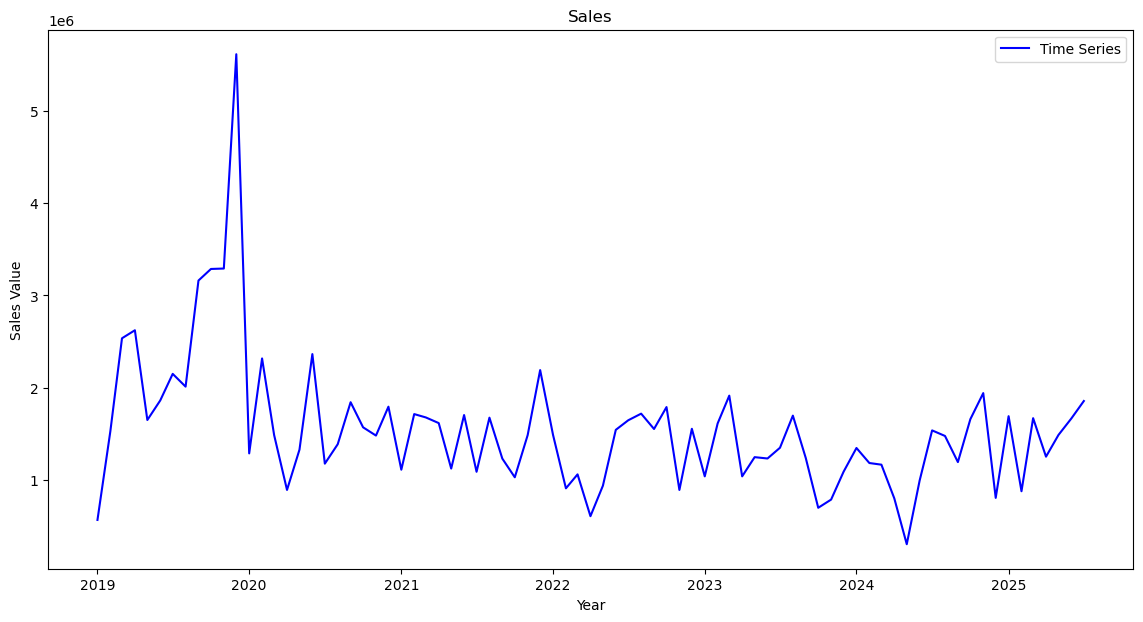

In [5]:
#Visualize the data
plt.figure(figsize=(14, 7))
plt.plot(df_monthly_sales.index, df_monthly_sales['Sales'], label='Time Series', color='Blue')
plt.title('Sales')
plt.xlabel('Year')
plt.ylabel('Sales Value')
plt.legend()
plt.show()

The data is cleaned and prepared for modeling

In [6]:
df_monthly_sales_log = np.log(df_monthly_sales)
train_df = df_monthly_sales_log.loc[:'2024-12-03']
test_df = df_monthly_sales_log.loc['2024-12-03':]

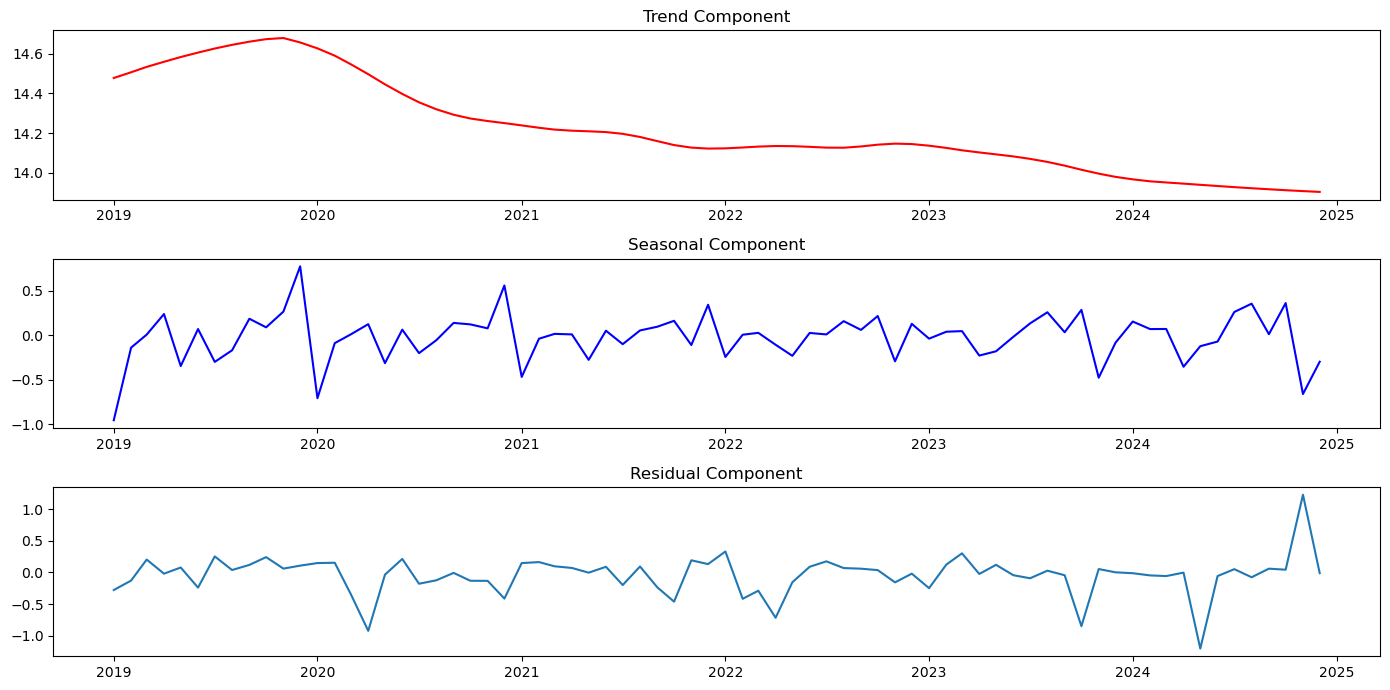

In [7]:
# Perform STL decomposition
stl = STL(train_df['Sales'], seasonal=13, robust=True) 
result = stl.fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

ax1.plot(train_df.index, result.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(train_df.index, result.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(train_df.index, result.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

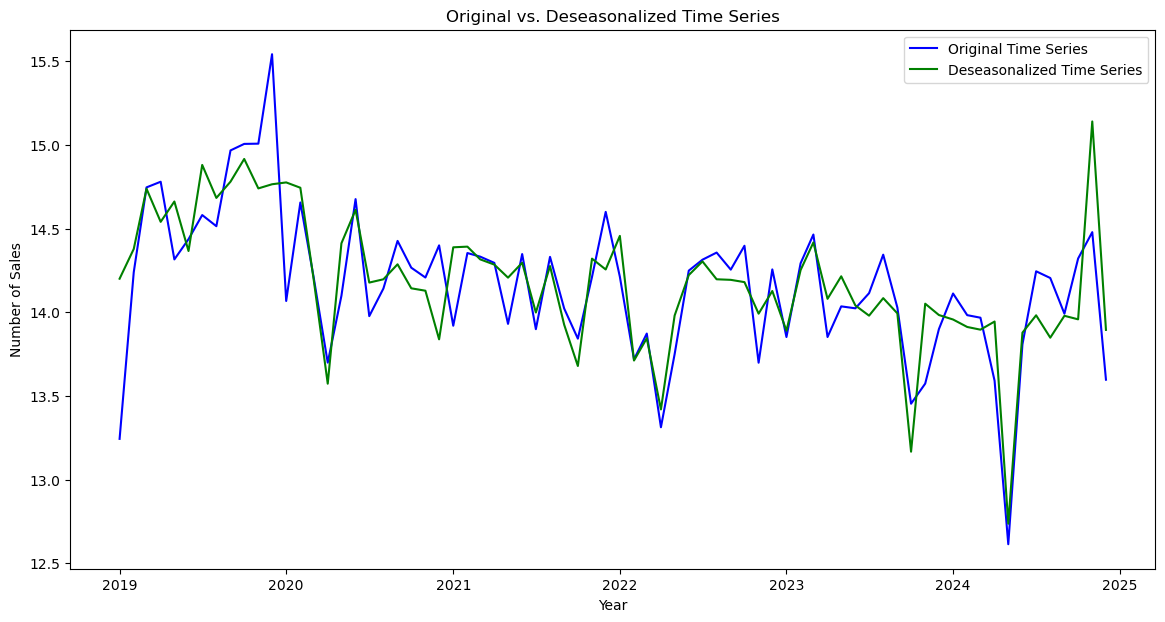

In [8]:
# Create a deseasonalized time series
deseasonalized_series = train_df['Sales'] - result.seasonal

# visualize the comparative plot
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df['Sales'], label='Original Time Series', color='blue')
plt.plot(deseasonalized_series.index, deseasonalized_series, label='Deseasonalized Time Series', color='green')
plt.title('Original vs. Deseasonalized Time Series')
plt.xlabel('Year')
plt.ylabel('Number of Sales')
plt.legend()
plt.show()

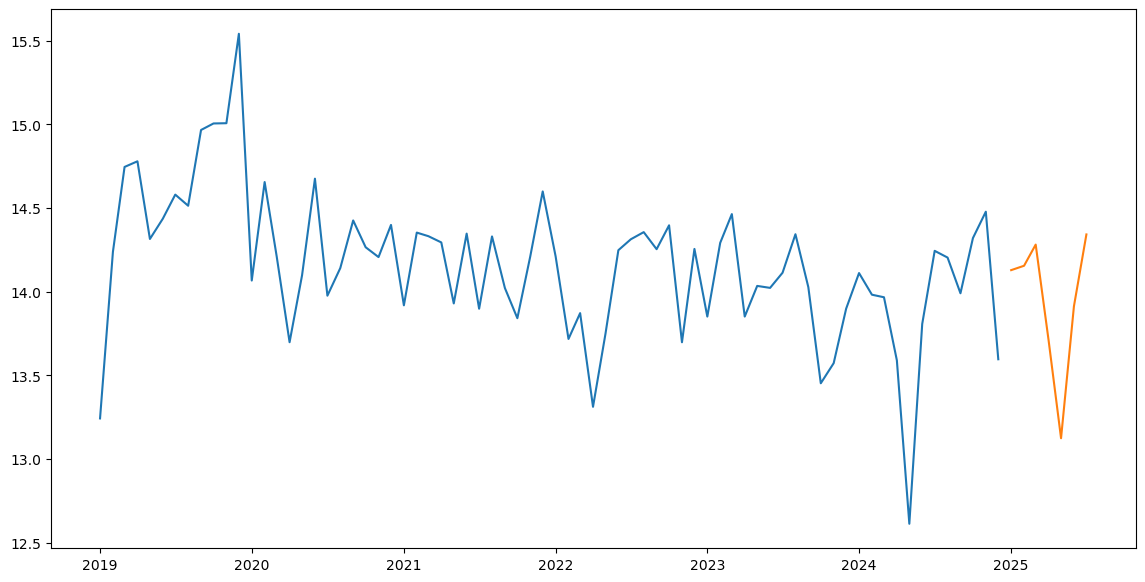

In [9]:
#create a forecast from the STL model
train_df.index.freq = train_df.index.inferred_freq
stlf = STLForecast(train_df, ARIMA, model_kwargs=dict(order=(3, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(len(test_df))
plt.figure(figsize=(14, 7))
plt.plot(train_df)
plt.plot(forecast)
plt.show()

In [10]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(3, 1, 0)   Log Likelihood                  -2.151
Date:                Mon, 22 Sep 2025   AIC                             14.302
Time:                        09:57:56   BIC                             25.616
Sample:                    01-01-2019   HQIC                            18.801
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0070      0.017     -0.419      0.675      -0.040       0.026
ar.L1         -0.4026      0.119     -3.370      0.001      -0.637      -0.168
ar.L2         -0.3195      0.136     -2.355      0.0

MAE: 0.37815907115363273
MSE: 0.24819874965606276
RMSE: 0.4981954934120367


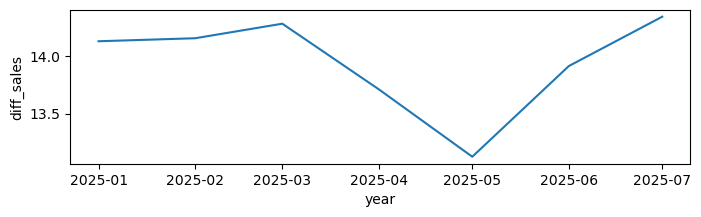

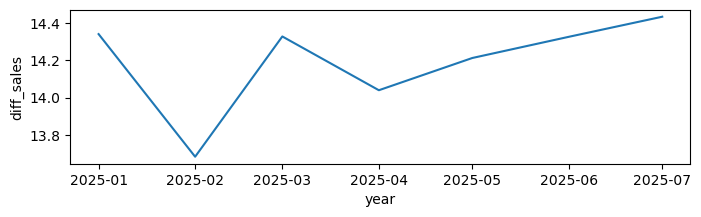

In [11]:
#generate a forecast and test is
forecast_steps = len(test_df)
forecast_result = forecast

# Calculate MAE
mae = mean_absolute_error(test_df, forecast_result)
print(f"MAE: {mae}")

# Calculate MSE
mse = mean_squared_error(test_df, forecast_result)
print(f"MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

#plot
plt.figure(figsize=(8,2))
plt.plot(forecast_result)
plt.xlabel('year')
plt.ylabel('diff_sales')
plt.show()
#plot
plt.figure(figsize=(8,2))
plt.plot(test_df)
plt.xlabel('year')
plt.ylabel('diff_sales')
plt.show()

In [12]:
#Transform the forecast into a df and append to the original to create a forecast csv
forecast_df = pd.DataFrame(forecast)
forecast_df = forecast_df.rename(columns={0: 'Sales'})
df_monthly_sales_forecast = pd.concat([forecast_df,df_monthly_sales])
df_monthly_sales_forecast = df_monthly_sales_forecast.reset_index()
df_monthly_sales_forecast.to_csv('monthly_sales_forecast.csv', index=False)

ARIMA Modeling and forecast:

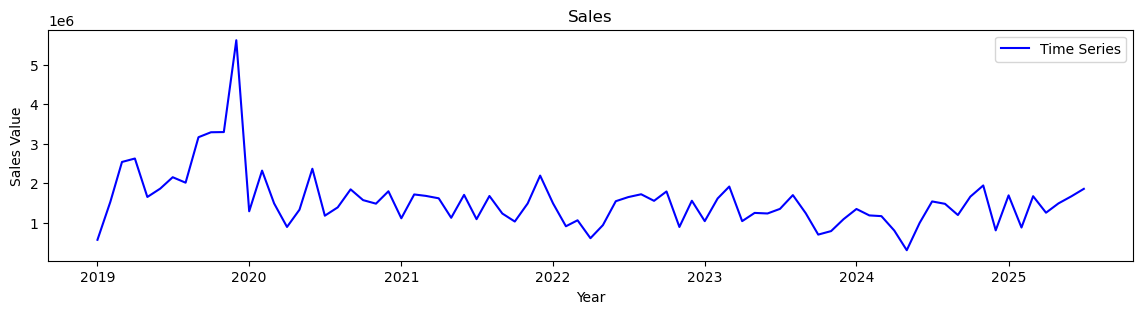

In [13]:
#start by visualizing the date then take a log if it appeasrs not to be stable.
plt.figure(figsize=(14, 3))
plt.plot(df_monthly_sales.index, df_monthly_sales['Sales'], label='Time Series', color='Blue')
plt.title('Sales')
plt.xlabel('Year')
plt.ylabel('Sales Value')
plt.legend()
plt.show()

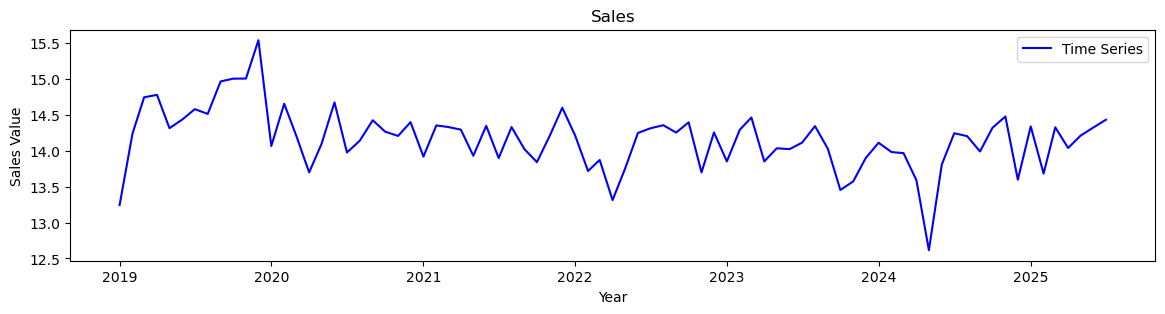

In [14]:
df_monthly_sales_log = np.log(df_monthly_sales)
plt.figure(figsize=(14, 3))
plt.plot(df_monthly_sales_log.index, df_monthly_sales_log['Sales'], label='Time Series', color='Blue')
plt.title('Sales')
plt.xlabel('Year')
plt.ylabel('Sales Value')
plt.legend()
plt.show()

Notice the stabalization in the data set where the time series is more evened out and variance isn't as wide. 

In [15]:
#Train test split, we are goign to split out the 2025 data and use that as the test. 
train_df = df_monthly_sales_log.loc[:'2024-12-03']
test_df = df_monthly_sales_log.loc['2024-12-03':]

ADF Statistic: -5.385019027006331
p-value: 3.6414501327203115e-06


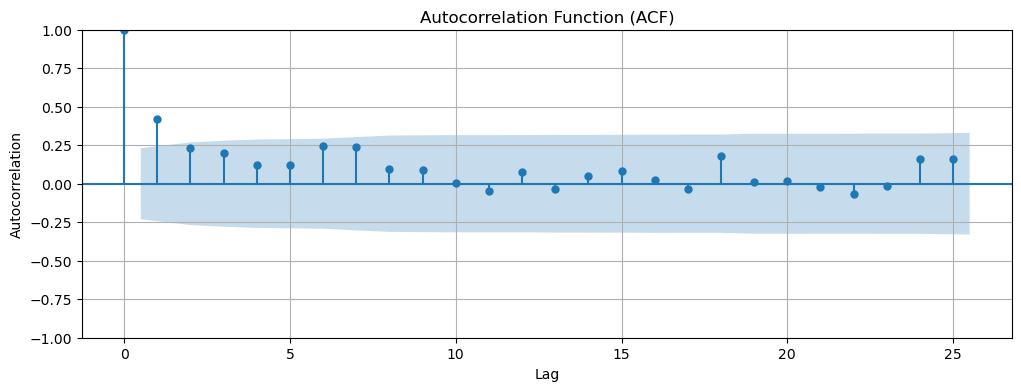

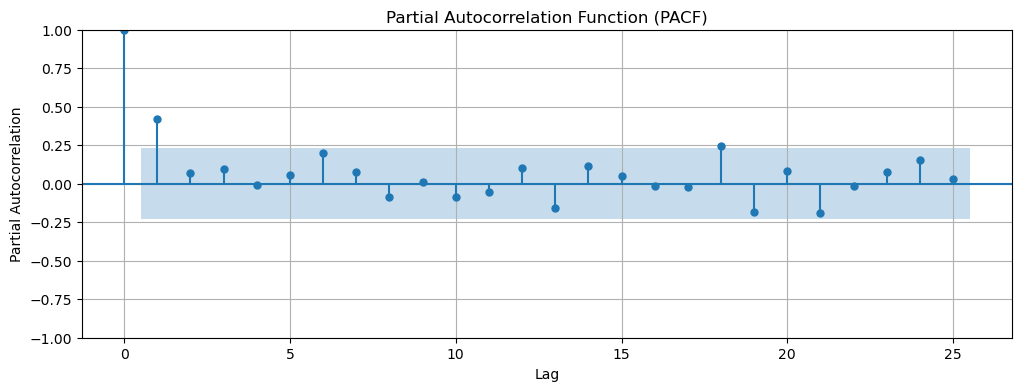

In [16]:
#find if data is stationary with ADFuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
#ACF plot
fig, ax = plt.subplots(figsize=(12, 4)) # Create a figure with a single subplot
plot_acf(train_df, lags=25, ax=ax) 
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()
#PACF Plot
fig, ax = plt.subplots(figsize=(12, 4)) # Create a figure with a single subplot
plot_pacf(train_df, lags=25, ax=ax, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Not only is the P-Value stationary, but also the ACF PACF display a visual of stationarity

In [17]:
#No differencing is needed for this
'''
#difference the data and visualize
df_monthly_sales_diff = df_monthly_sales.diff().dropna()
result = adfuller(df_monthly_sales_diff['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

#plot
plt.figure(figsize=(8,4))
plt.plot(df_monthly_sales_diff)
plt.xlabel('year')
plt.ylabel('diff_sales')
plt.show()
'''

"\n#difference the data and visualize\ndf_monthly_sales_diff = df_monthly_sales.diff().dropna()\nresult = adfuller(df_monthly_sales_diff['Sales'])\nprint('ADF Statistic:', result[0])\nprint('p-value:', result[1])\n\n#plot\nplt.figure(figsize=(8,4))\nplt.plot(df_monthly_sales_diff)\nplt.xlabel('year')\nplt.ylabel('diff_sales')\nplt.show()\n"

In [18]:
#fit ARMA model on differenced data
model = ARIMA(train_df, order=(1,0,0))
model_fit_ARIMA = model.fit()

print(model_fit_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   72
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -34.967
Date:                Mon, 22 Sep 2025   AIC                             75.935
Time:                        09:57:57   BIC                             82.765
Sample:                    01-01-2019   HQIC                            78.654
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1432      0.089    159.126      0.000      13.969      14.317
ar.L1          0.4518      0.093      4.834      0.000       0.269       0.635
sigma2         0.1542      0.027      5.662      0.0

c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE: 0.23804072704249585
MSE: 0.07237730301993342
RMSE: 0.26903030130439476


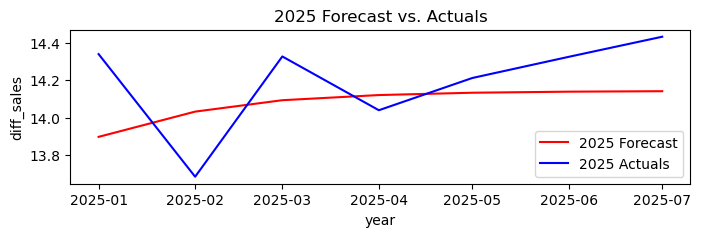

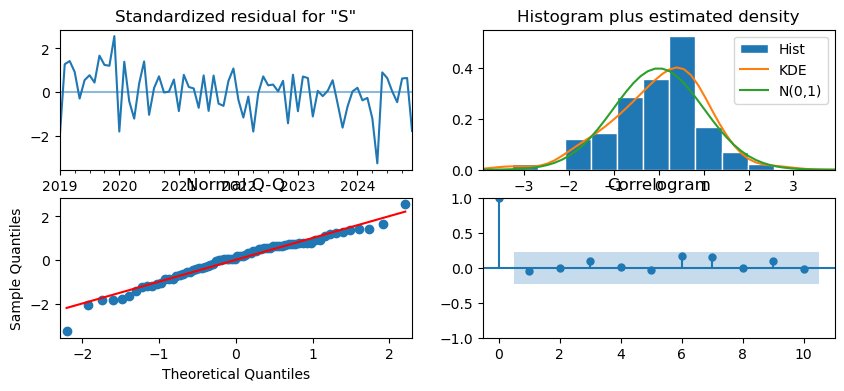

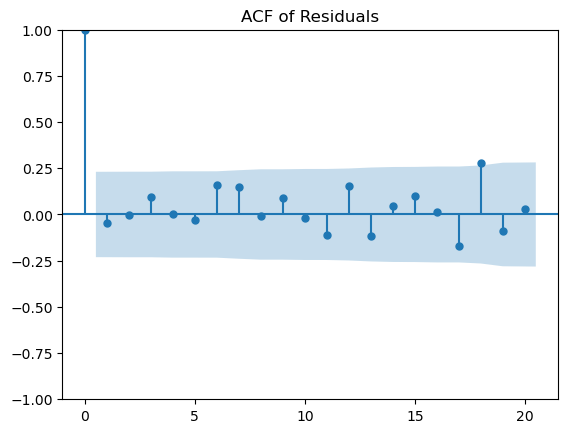

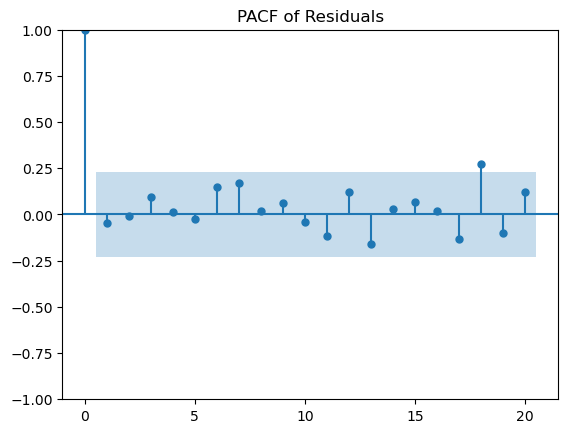

In [19]:
#generate a forecast and test is
forecast_steps = len(test_df)
forecast_result = model_fit_ARIMA.forecast(steps=forecast_steps)

# Calculate MAE: Measures avg absolute difference between actuals and predicted 
mae = mean_absolute_error(test_df, forecast_result)
print(f"MAE: {mae}")

# Calculate MSE: avg squared difference between actuals and predict  
mse = mean_squared_error(test_df, forecast_result)
print(f"MSE: {mse}")

# Calculate RMSE: provides error in same units as target variable
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

#plot
plt.figure(figsize=(8,2)) # Define the figure size
plt.plot(forecast_result, color='red', label='2025 Forecast') # Plot forecast_result in red
plt.plot(test_df, color='blue', label='2025 Actuals') # Plot test_df in blue
plt.xlabel('year')
plt.ylabel('diff_sales')
plt.title('2025 Forecast vs. Actuals')  # A more descriptive title
plt.legend()  # Display the legend to identify the lines
plt.show()

# Plot residuals
model_fit_ARIMA.plot_diagnostics(figsize=(10, 4))
plt.show()

# Check for autocorrelation in residuals
plot_acf(model_fit_ARIMA.resid, lags=20)
plt.title('ACF of Residuals')
plt.show()

plot_pacf(model_fit_ARIMA.resid, lags=20)
plt.title('PACF of Residuals')
plt.show()


In [20]:
test_df_ = np.exp(test_df)
forecast_result_round = np.exp(forecast_result)
forecast_result_ = np.round(forecast_result_round, decimals=0)
diff_df = pd.concat([forecast_result_,test_df_],axis=1)
diff_df['Difference']=diff_df['predicted_mean']-diff_df['Sales']
diff_df

,predicted_mean,Sales,Difference
2025-01-01,1084207.0,1689630.57,-605423.57
2025-02-01,1241333.0,875660.25,365672.75
2025-03-01,1319600.0,1668320.56,-348720.56
2025-04-01,1356559.0,1250591.02,105967.98
2025-05-01,1373594.0,1486397.37,-112803.37
2025-06-01,1381360.0,1665250.34,-283890.34
2025-07-01,1384883.0,1854510.46,-469627.46


In [21]:
diff_df['Difference'].abs().mean()

327443.7185714285

SARIMA Model

In [22]:
p, d, q = 2, 0, 1
P, D, Q, m = 4, 0, 1, 3 # For example, monthly data with a seasonal period of 12

model = SARIMAX(train_df['Sales'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False, # Set to False if differencing was done manually
                enforce_invertibility=False) # {Link: According to a Number Analytics blog post https://www.numberanalytics.com/blog/practical-sarima-implementation}, These options help with convergence issues.

model_fit_SARIMA = model.fit()

# Print the model summary to review statistics
print(model_fit_SARIMA.summary())

c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                   72
Model:             SARIMAX(2, 0, 1)x(4, 0, 1, 3)   Log Likelihood                 -19.131
Date:                           Mon, 22 Sep 2025   AIC                             56.261
Time:                                   09:57:58   BIC                             74.805
Sample:                               01-01-2019   HQIC                            63.484
                                    - 12-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0151      0.359      2.828      0.005       0.312       1.719
ar.L2         -0.2159      0.207     -1.043

c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 0.47410412112943845
MSE: 0.26290041824291555
RMSE: 0.5127381575842738


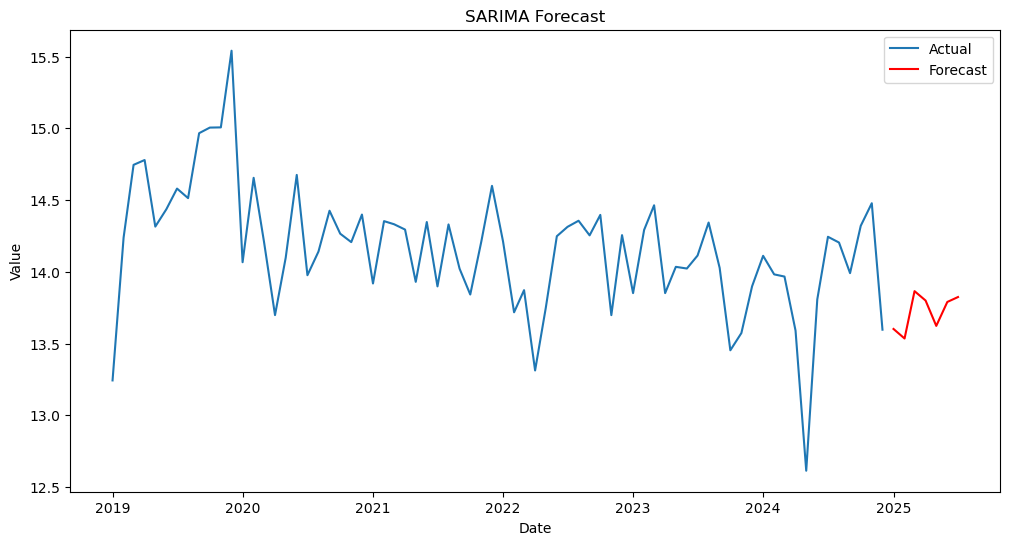

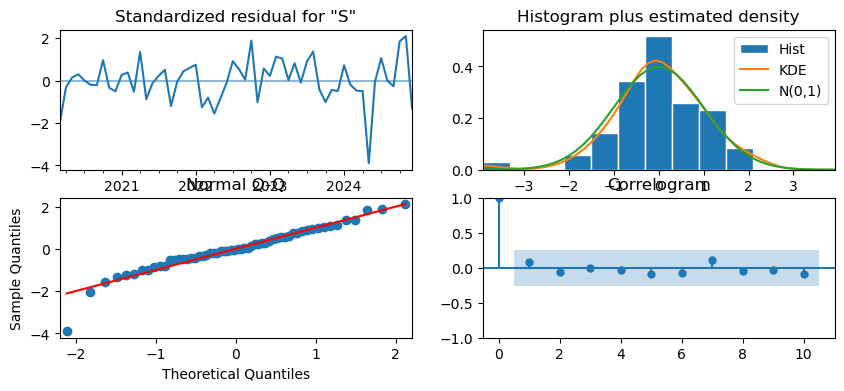

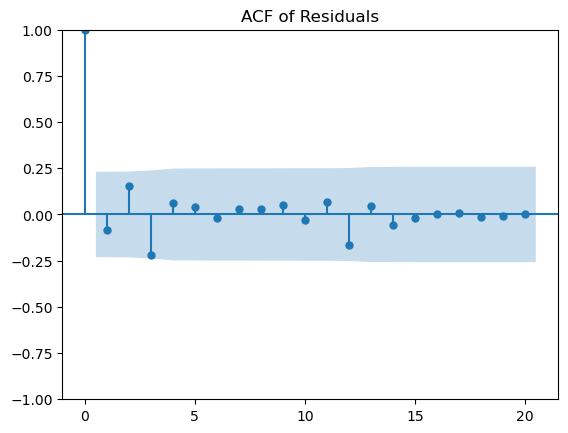

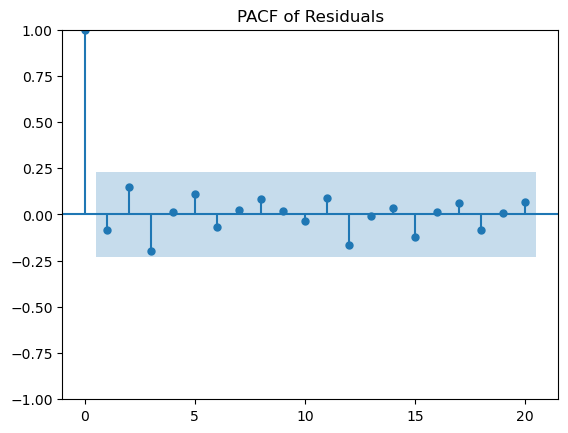

In [23]:
forecast_steps = len(test_df)
forecast = model_fit_SARIMA.predict(start=len(train_df), end=len(train_df) + forecast_steps - 1)

#Error Testing
# Calculate MAE
mae = mean_absolute_error(test_df, forecast)
print(f"MAE: {mae}")

# Calculate MSE
mse = mean_squared_error(test_df, forecast)
print(f"MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_df, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot residuals
model_fit_SARIMA.plot_diagnostics(figsize=(10, 4))
plt.show()

# Check for autocorrelation in residuals
plot_acf(model_fit_SARIMA.resid, lags=20)
plt.title('ACF of Residuals')
plt.show()

plot_pacf(model_fit_SARIMA.resid, lags=20)
plt.title('PACF of Residuals')
plt.show()

Create a Multivariat ARIMA model based on sales, cogs, actual sale counts, and return counts

In [24]:
from statsmodels.tsa.statespace.varmax import VARMAX

Augmented Dickey-Fuller Test Results:
----------------------------------------
For column: Sales
  ADF Statistic: -2.0151918475825594
  p-value: 0.279951984690272
----------------------------------------
For column: Unit Cost
  ADF Statistic: -1.5020326180691825
  p-value: 0.5325055932394822
----------------------------------------
For column: Actual Sale
  ADF Statistic: -0.7068941189040422
  p-value: 0.8449557148431693
----------------------------------------
For column: Return
  ADF Statistic: -2.9466786006163947
  p-value: 0.04018297040811461
----------------------------------------


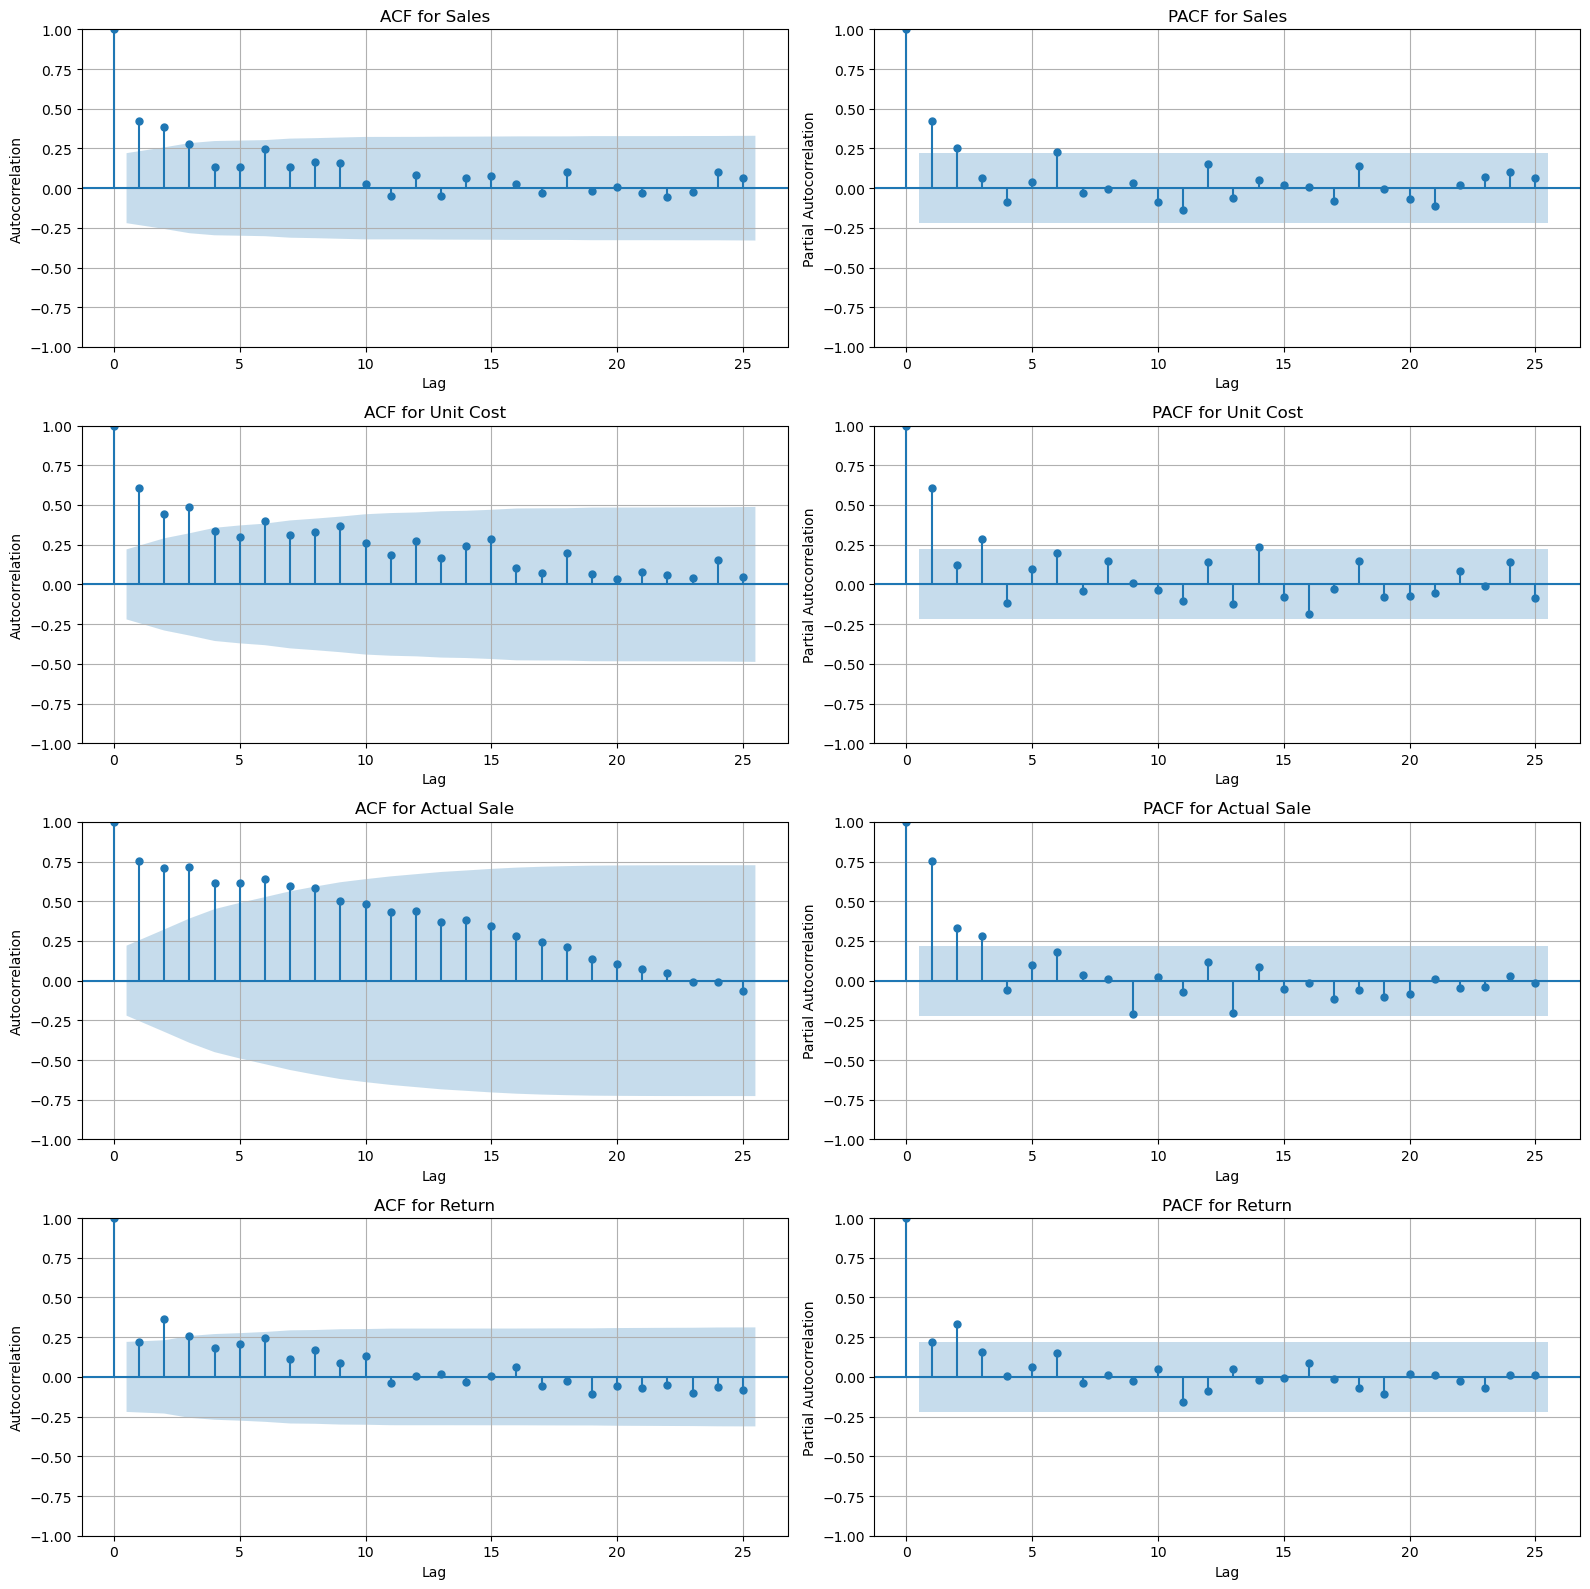

In [25]:
#find if data is stationary with ADFuller test on all variables except sales since we confirmed it is via earlier tests
columns_to_test = ['Sales', 'Unit Cost', 'Actual Sale', 'Return']

print("Augmented Dickey-Fuller Test Results:")
print("-" * 40)

for column in columns_to_test:
    print(f"For column: {column}")
    result = adfuller(df_monthly_sales_mv[column])
    print('  ADF Statistic:', result[0])
    print('  p-value:', result[1])
    print("-" * 40)

# List of columns to plot
columns_to_plot = ['Sales', 'Unit Cost', 'Actual Sale', 'Return']
num_columns = len(columns_to_plot)

# Create a figure and a grid of subplots (num_columns rows, 2 columns)
fig, axes = plt.subplots(num_columns, 2, figsize=(16, 4 * num_columns)) # Adjust figsize as needed

# Iterate through each column to plot ACF and PACF
for i, column in enumerate(columns_to_plot):
    # Plot ACF in the first column of the current row
    plot_acf(df_monthly_sales_mv[column], lags=25, ax=axes[i, 0])
    axes[i, 0].set_title(f'ACF for {column}')
    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('Autocorrelation')
    axes[i, 0].grid(True)

    # Plot PACF in the second column of the current row
    plot_pacf(df_monthly_sales_mv[column], lags=25, ax=axes[i, 1], method='ywm')
    axes[i, 1].set_title(f'PACF for {column}')
    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('Partial Autocorrelation')
    axes[i, 1].grid(True)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plot
plt.show()

Augmented Dickey-Fuller Test Results:
----------------------------------------
For column: Sales
  ADF Statistic: -6.382391950772789
  p-value: 2.2059357796716444e-08
----------------------------------------
For column: Unit Cost
  ADF Statistic: -4.6602428677025785
  p-value: 9.987948748169598e-05
----------------------------------------
For column: Actual Sale
  ADF Statistic: -5.095617123871518
  p-value: 1.4306286712482811e-05
----------------------------------------
For column: Return
  ADF Statistic: -10.407165744211678
  p-value: 1.8439510388121942e-18
----------------------------------------


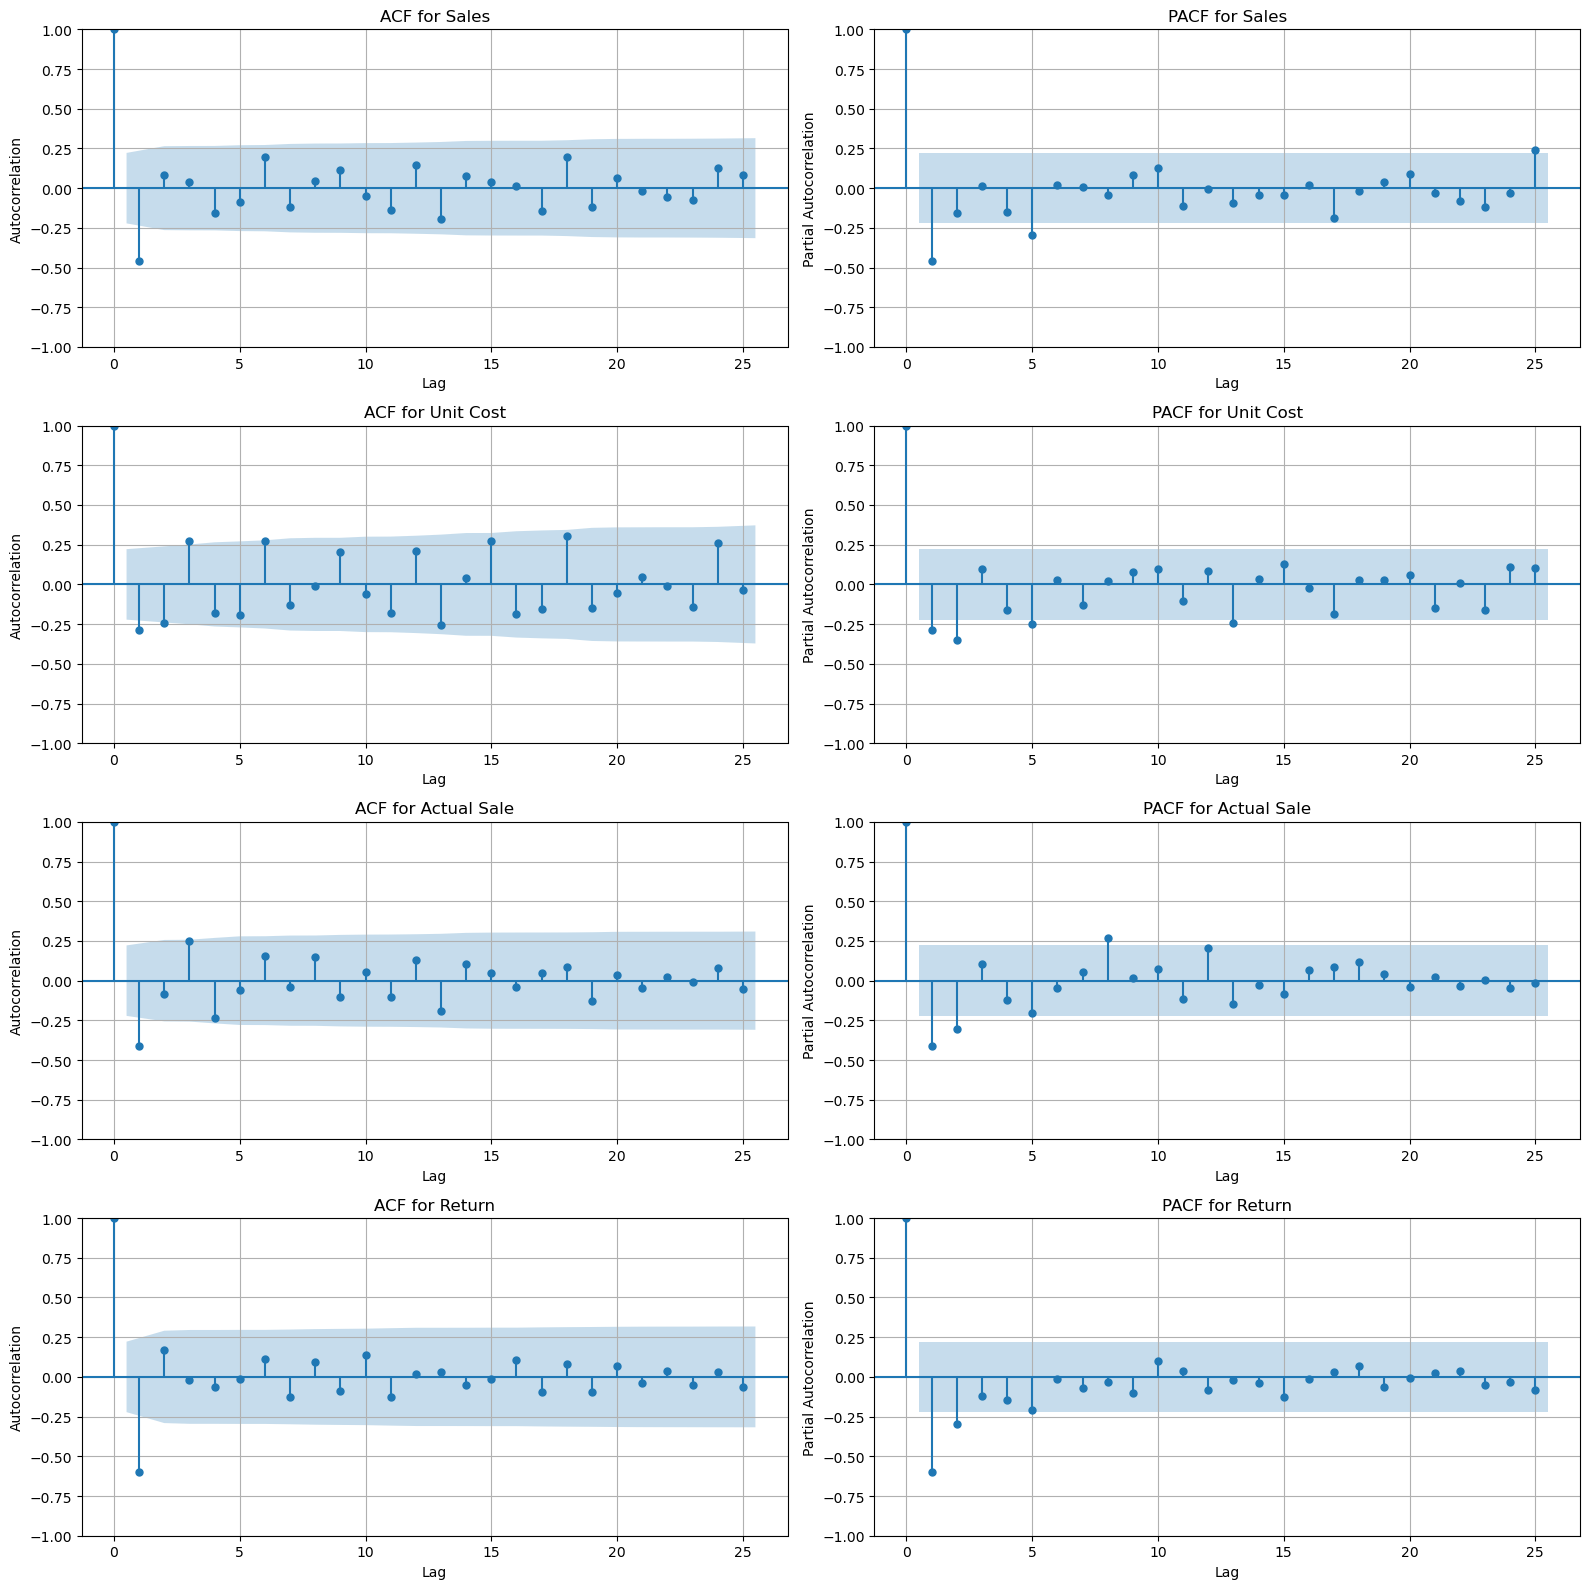

In [26]:
#difference the data and visualize
df_monthly_sales_mv_diff = df_monthly_sales_mv[['Sales', 'Unit Cost', 'Actual Sale','Return']].diff().dropna()
columns_to_test = ['Sales', 'Unit Cost', 'Actual Sale', 'Return']

print("Augmented Dickey-Fuller Test Results:")
print("-" * 40)

for column in columns_to_test:
    print(f"For column: {column}")
    result = adfuller(df_monthly_sales_mv_diff[column])
    print('  ADF Statistic:', result[0])
    print('  p-value:', result[1])
    print("-" * 40)

# List of columns to plot
columns_to_plot = ['Sales', 'Unit Cost', 'Actual Sale', 'Return']
num_columns = len(columns_to_plot)

# Create a figure and a grid of subplots (num_columns rows, 2 columns)
fig, axes = plt.subplots(num_columns, 2, figsize=(16, 4 * num_columns)) # Adjust figsize as needed

# Iterate through each column to plot ACF and PACF
for i, column in enumerate(columns_to_plot):
    # Plot ACF in the first column of the current row
    plot_acf(df_monthly_sales_mv_diff[column], lags=25, ax=axes[i, 0])
    axes[i, 0].set_title(f'ACF for {column}')
    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('Autocorrelation')
    axes[i, 0].grid(True)

    # Plot PACF in the second column of the current row
    plot_pacf(df_monthly_sales_mv_diff[column], lags=25, ax=axes[i, 1], method='ywm')
    axes[i, 1].set_title(f'PACF for {column}')
    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('Partial Autocorrelation')
    axes[i, 1].grid(True)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plot
plt.show()

In [27]:
#split the data
train_df_mv = df_monthly_sales_mv.loc[:'2024-12-03']
test_df_mv = df_monthly_sales_mv.loc['2024-12-03':]

In [28]:
p, d, q = 1, 1, 1 # d is 1 based on the above analysis 
model = VARMAX(train_df_mv, order=(p, d, q), trend='c') 
results = model.fit(disp=False) # disp=False suppresses convergence messages
print(results.summary()) #

c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                          Statespace Model Results                                         
Dep. Variable:     ['Sales', 'Unit Cost', 'Actual Sale', 'Return']   No. Observations:                   72
Model:                                                  VARMA(1,1)   Log Likelihood               -2734.612
                                                       + intercept   AIC                           5561.224
Date:                                             Mon, 22 Sep 2025   BIC                           5665.950
Time:                                                     09:58:02   HQIC                          5602.916
Sample:                                                 01-01-2019                                         
                                                      - 12-01-2024                                         
Covariance Type:                                               opg                                         
Ljung-Box (L1) (Q):     0.00

c:\Users\ti290f\DevopsSetupPrograms\Anaconda\envs\python39\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Metrics for Sales:
  MAE: 263560.58
  RMSE: 293210.14
Metrics for Unit Cost:
  MAE: 105072.43
  RMSE: 134870.53
Metrics for Actual Sale:
  MAE: 43.80
  RMSE: 50.52
Metrics for Return:
  MAE: 5.78
  RMSE: 6.90


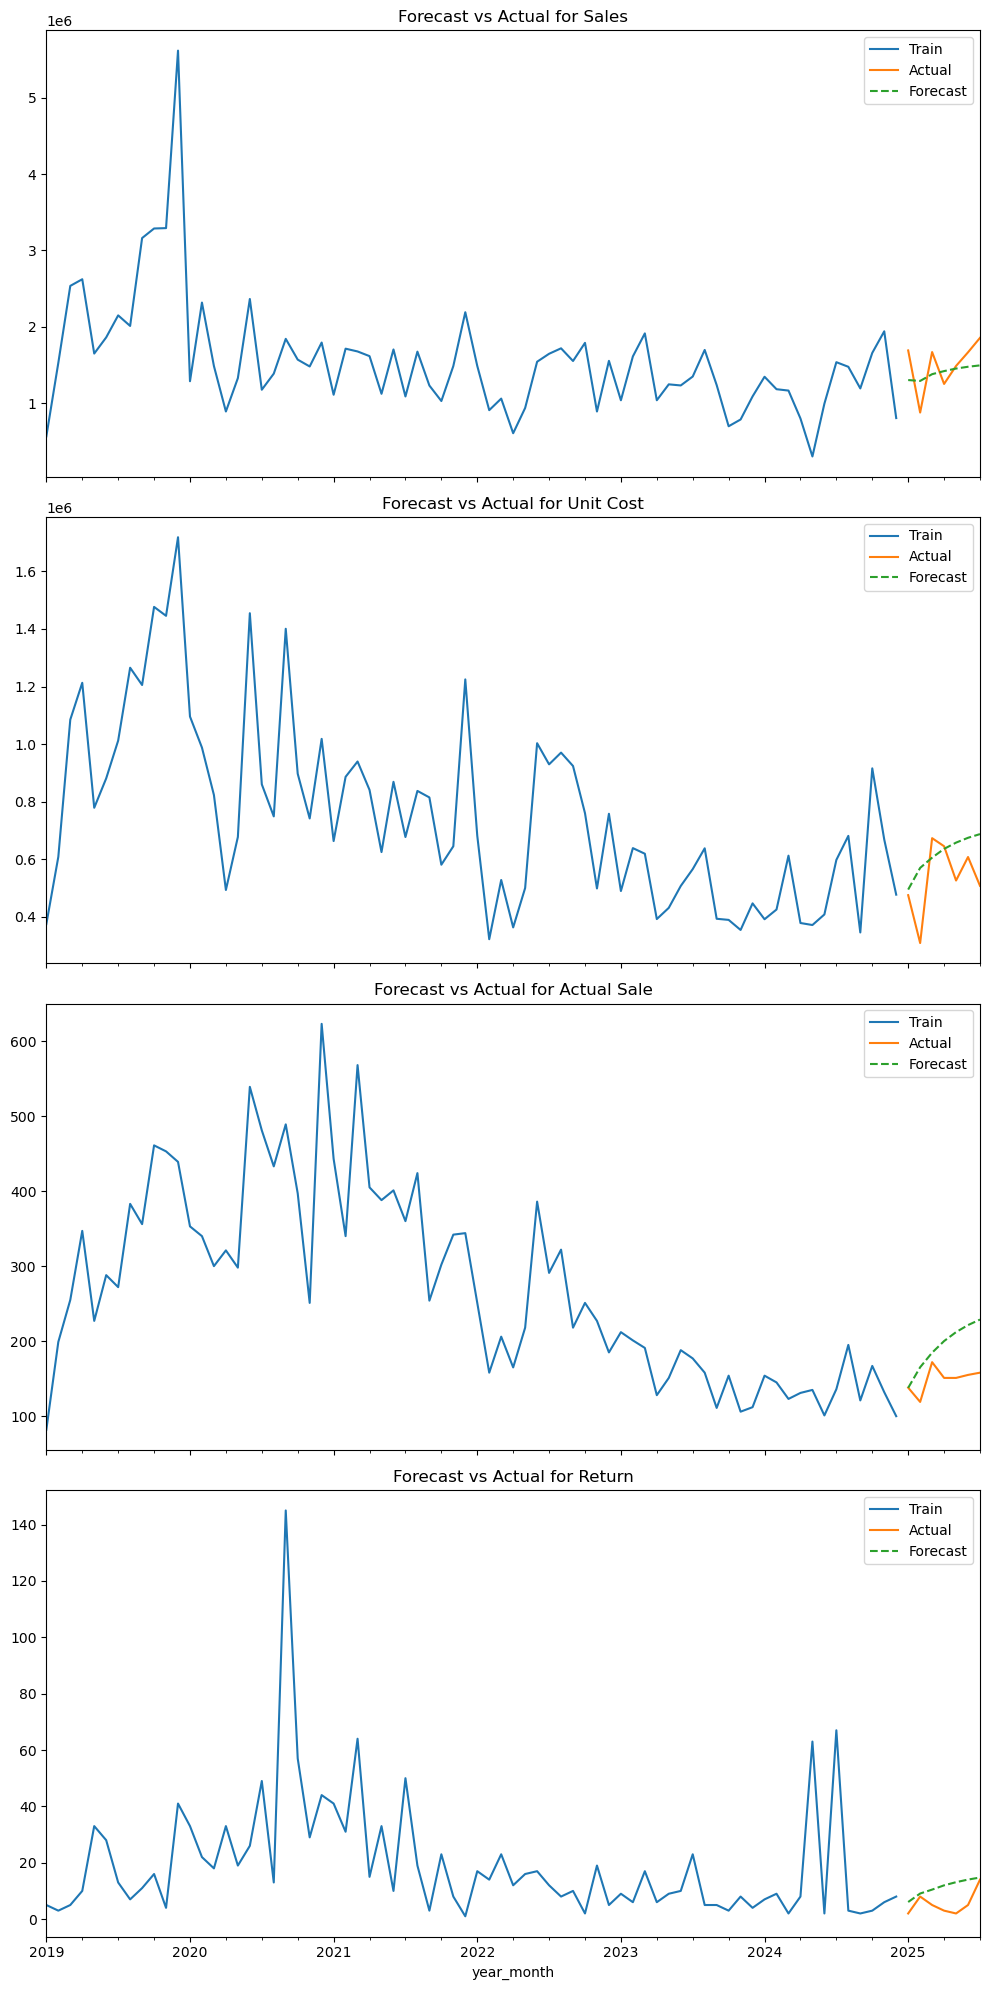

In [41]:
forecast_steps = len(test_df_mv)
forecast_results = results.forecast(steps=forecast_steps)

for column in test_df_mv.columns:
    actual = test_df_mv[column]
    predicted = forecast_results[column]

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    print(f"Metrics for {column}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")

# Create a figure with a subplot for each variable
n_series = len(test_df_mv.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(10, 5 * n_series), sharex=True)

# Loop through each series and plot the actual vs. forecast
for i, column in enumerate(test_df_mv.columns):
    # Plot training data for context
    train_df_mv[column].plot(ax=axes[i], label='Train', linestyle='-')
    
    # Plot test data as actual values
    test_df_mv[column].plot(ax=axes[i], label='Actual', linestyle='-')
    
    # Plot forecast data
    forecast_results[column].plot(ax=axes[i], label='Forecast', linestyle='--')
    
    # Add titles and legends
    axes[i].set_title(f'Forecast vs Actual for {column}')
    axes[i].legend()

# Improve layout and display
plt.tight_layout()
plt.show()
